# **Lê Nguyễn Tuyết Nhi - 521h0364**
# **Trương Gia Bảo - 521h0201** 
# **Vi Thành Đạt - 521h0390**

# **Final Project** 

In [1]:
!pip install datasets gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 49.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 w

In [2]:
# Import libraries
import tensorflow as tf
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

# Load dataset
dataset = load_dataset("opus100", "en-vi")
train_data = dataset["train"]

README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/59.0M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/138k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
# Extract sentences
vi_sentences_train = ['<sos>' + example["translation"]["vi"].lower() + '<eos>' for example in train_data]
en_sentences_train = ['<sos>' + example["translation"]["en"].lower() + '<eos>' for example in train_data]

In [4]:
# Limit dataset size
max_dataset_size = 300000
vi_sentences_train = vi_sentences_train[:max_dataset_size]
en_sentences_train = en_sentences_train[:max_dataset_size]

In [5]:
vi_sentences_train[:1]

['<sos>cái gì đó?<eos>']

In [6]:
en_sentences_train[:1]

['<sos>what is it?<eos>']

In [7]:
# Tokenization
max_vocab_size = 60000
max_sequence_length = 30

vi_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<unk>")
en_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<unk>")

vi_tokenizer.fit_on_texts(vi_sentences_train)
en_tokenizer.fit_on_texts(en_sentences_train)

vi_sequences_train = pad_sequences(vi_tokenizer.texts_to_sequences(vi_sentences_train), maxlen=max_sequence_length, padding='post')
en_sequences_train = pad_sequences(en_tokenizer.texts_to_sequences(en_sentences_train), maxlen=max_sequence_length, padding='post')

In [8]:
# Step 2: Load Pre-trained FastText Embeddings
# Download and load FastText vectors
!wget -q -O wiki-news-300d-1M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip -q wiki-news-300d-1M.vec.zip

fasttext_model = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)
embedding_dim = 300

# Create embedding matrix
def create_embedding_matrix(tokenizer, embedding_dim, fasttext_model):
    n_words = len(tokenizer.word_index) + 1  # Include padding token
    embedding_matrix = np.zeros((n_words, embedding_dim))  # Initialize matrix with zeros

    for word, i in tokenizer.word_index.items():
        if word in fasttext_model.key_to_index:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.randn(embedding_dim)  # Random initialization for OOV words
    return embedding_matrix

vi_embedding_matrix = create_embedding_matrix(vi_tokenizer, embedding_dim, fasttext_model)
en_embedding_matrix = create_embedding_matrix(en_tokenizer, embedding_dim, fasttext_model)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
# Define the encoder-decoder model without attention
# Encoder
encoder_input = Input(shape=(max_sequence_length,), name="Encoder_Input")
encoder_embedding = Embedding(
    input_dim=len(vi_tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[vi_embedding_matrix],
    trainable=False,
    name="Encoder_Embedding"
)(encoder_input)
encoder_lstm = LSTM(256, return_state=True, name="Encoder_LSTM", dropout=0.3, recurrent_dropout=0.3)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(max_sequence_length,), name="Decoder_Input")
decoder_embedding = Embedding(
    input_dim=len(en_tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[en_embedding_matrix],
    trainable=False,
    name="Decoder_Embedding"
)(decoder_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3, name="Decoder_LSTM")
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Dense Output Layer
decoder_dense = Dense(max_vocab_size, activation="softmax", name="Output_Layer")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_input, decoder_input], decoder_outputs, name="LSTM_Encoder-Decoder_Model")

# Compile Model
learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "LSTM_Encoder-Decoder_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Embedding   │ (None, 30, 300)   │ 10,559,100 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Embedding   │ (None, 30, 300)   │ 16,146,300 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_LSTM (LSTM) │ [(None, 256),     │    570,368 │ Encoder_Embeddin… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_LSTM (LSTM) │ [(None, 30, 256), │    570,368 │ Decoder_Embeddin… │
│                     │ (None, 256),      │            │ Encoder_LSTM[0][… │
│                     │ (None, 256)]      │            │ Encoder_LSTM[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 30, 60000) │ 15,420,000 │ Decoder_LSTM[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,266,136 (165.05 MB)

 Trainable params: 16,560,736 (63.17 MB)

 Non-trainable params: 26,705,400 (101.87 MB)

In [10]:
# Prepare Decoder Inputs and Targets
decoder_input_data_train = np.zeros_like(en_sequences_train)
decoder_input_data_train[:, 1:] = en_sequences_train[:, :-1]  # Shift by one position
decoder_target_data_train = np.zeros_like(en_sequences_train)
decoder_target_data_train[:, :-1] = en_sequences_train[:, 1:]  # Shift target by one position

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [11]:
# Train Model
history = model.fit(
    [vi_sequences_train, decoder_input_data_train],
    decoder_target_data_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1089s 289ms/step - accuracy: 0.7764 - loss: 1.8476 - val_accuracy: 0.7905 - val_loss: 1.4281
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1092s 291ms/step - accuracy: 0.7920 - loss: 1.3951 - val_accuracy: 0.7976 - val_loss: 1.3619
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1092s 291ms/step - accuracy: 0.7969 - loss: 1.3285 - val_accuracy: 0.8014 - val_loss: 1.3220
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1091s 291ms/step - accuracy: 0.8007 - loss: 1.2731 - val_accuracy: 0.8041 - val_loss: 1.2972
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1091s 291ms/step - accuracy: 0.8029 - loss: 1.2345 - val_accuracy: 0.8060 - val_loss: 1.2818
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1093s 291ms/step - accuracy: 0.8038 - loss: 1.2081 - val_accuracy: 0.8073 - val_loss: 1.2706
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1092s 291ms/step - accuracy: 0.8051 - loss: 1.1840 - val_accuracy: 0.8084 - val_loss: 1.2640
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1092s 291ms/s

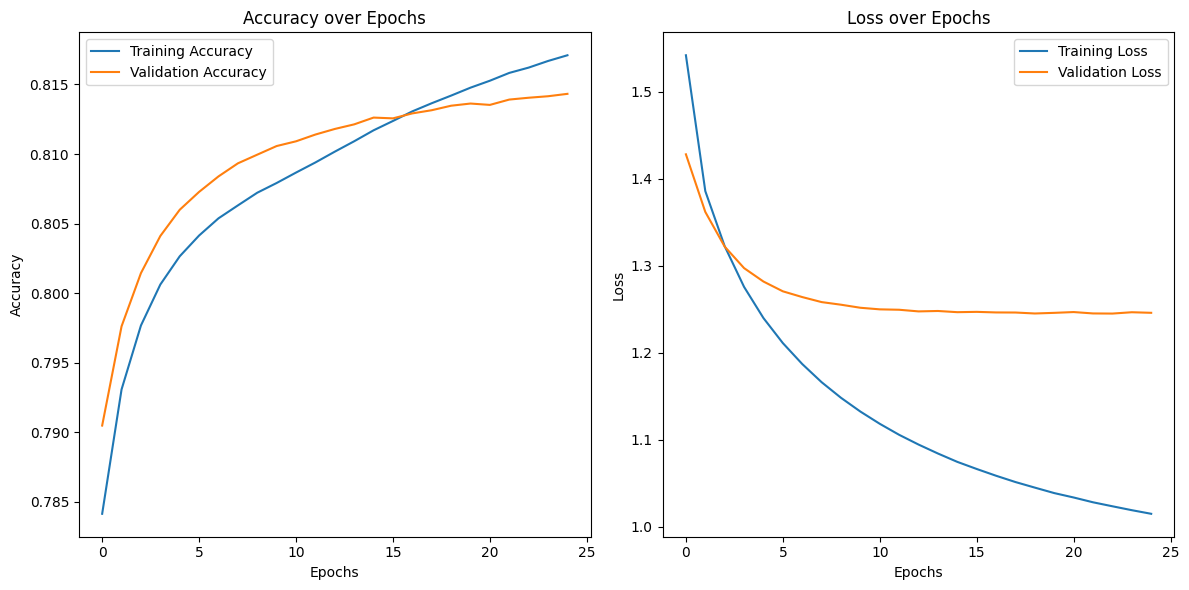

In [12]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
def translate_with_attention(vi_sentence):
    # Preprocess input sentence
    sequence = vi_tokenizer.texts_to_sequences(['<sos> ' + vi_sentence + ' <eos>'])
    sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')

    # Initialize decoder input
    decoder_input = np.zeros((1, max_sequence_length))
    decoder_input[0, 0] = en_tokenizer.word_index.get('<sos>', 1)

    translated_sentence = []
    attention_weights = []

    for i in range(max_sequence_length - 1):
        # Predict the next token
        prediction = model.predict([sequence, decoder_input], verbose=0)
        predicted_id = np.argmax(prediction[0, i])

        # Save attention weights
        attention_weights.append(prediction[0, i])

        # Stop if <eos> token is predicted
        if predicted_id == en_tokenizer.word_index.get('<eos>', 0) or predicted_id == 0:
            break

        # Append the predicted word to the translated sentence
        translated_sentence.append(en_tokenizer.index_word.get(predicted_id, '<unk>'))
        decoder_input[0, i + 1] = predicted_id

    return ' '.join(translated_sentence), np.array(attention_weights)


In [14]:
# Example
vi_sentence = "xin chào"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: xin chào
Translated: me eos


In [15]:
# Example
vi_sentence = "cảm ơn"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: cảm ơn
Translated: you eos


In [16]:
# Example
vi_sentence = "tạm biệt"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: tạm biệt
Translated: good eos


In [17]:
# Example
vi_sentence = "hôm nay là thứ hai"
translated_sentence, attention_weights = translate_with_attention(vi_sentence)
print(f"Original: {vi_sentence}")
print(f"Translated: {translated_sentence}")

Original: hôm nay là thứ hai
Translated: this twice twice twice
